In [437]:
import numpy as np
from matplotlib import pyplot as plt

class Color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'
    
class TSWindow():
    def __init__(self, 
                 input_size=1, 
                 gap=0, 
                 label_size=1,
                ):
        if not isinstance(input_size, int):
            raise Exception("Input error. Dtype not expected on \x1B[3m input_size \x1B[0m. It should be int.")
        elif input_size < 1:
            raise Exception("Input error. \x1B[3m input_size \x1B[0m must be 1 at least.")
        self.input_size = input_size
        self.gap = gap
        self.label_size = label_size
        self.total_size = self.input_size + self.gap + self.label_size
    def _window_dataset(self, data):
        _, _, self.length = data.shape
        if self.input_size < 1 or self.total_size > self.length:
            raise Exception("Input error. Length of time series must be equal to \x1B[3m input_size \x1B[0m at least.")
        # Treat even splits
        self.start_indices = np.arange(0, self.length - self.total_size + 1, 1)
        self.n_splits = len(self.start_indices)
        # Treat remainder split
        # Remainder split starts at, total length of time series, minus, total_size
        # Note that the remainder start index is always greater than last start index (at least 1 step). When even both index
        # are equal, the split is even.
        print(self.length, self.total_size, self.length % self.total_size != 0)
        print(self.start_indices)
        self.show_index()
        x_stack = []
        y_stack = []
        for start in self.start_indices:
            x_stack.append(data[..., slice(start, start + self.input_size)])
            y_stack.append(data[..., slice(start + self.input_size + self.gap, start + self.total_size)])
        X = np.transpose(np.stack(x_stack, axis=2), axes=(0, 2, 1, 3))
        y = np.transpose(np.stack(y_stack, axis=2), axes=(0, 2, 1, 3))
        return X, y
    def extract_sets(self, data, splits_into_batch=True, return_indices=False):
        """ Desc: 
            Input:
                - self. General object
                - X, numpy array (row, col), array of time series
            Output:
                - data , numpy array, array of data without target
                - target, numpy array, array of target values
        """
        if self.label_size == 0:
            raise Exception("Target setup error: No target points assigned")
        X_window, y_window = self._window_dataset(data)
        if splits_into_batch:
            # Transpose batches and splits in order to stack splits properly
            m, s, *other_dims = X_window.shape
            
            X_window = X_window.reshape(s * m, *other_dims)
            y_window = y_window.reshape(s * m, *y_window.shape[2:])
        if return_indices:
            return X_window, y_window, self.start_indices
        return X_window, y_window, None
    def show_index(self):
        print("Input start:", self.start_indices)
        print("Input end:", self.start_indices + self.input_size)
        print("Label start:", self.start_indices + self.input_size + self.gap)
        print("Label end:", self.start_indices + self.input_size + self.gap + self.label_size)
    
    def plot_splits(self, 
                    data,
                    data_win, 
                    labels, 
                    batch=0, 
                    feature=0, 
                    figsize=(12, 6),
                   ):
        # Full data plot parameters
        linestyle_full_data = "-."
        marker_full_data = "o"
        size_full_data = 25
        # Split data plot parameters
        linestyle_split_data = "--"
        marker_split_data = "*"
        # Target plot parameters
        size = 100
        alpha = 0.6
        target_marker = "o"
        target_facecolor = "red"
        target_edgecolor = "black"
        
        sample_data = data[batch, feature]
        sample_data_splits = data_win[batch, :, feature]
        sample_labels_split = labels[batch, :, feature]
        
        n_splits = len(sample_ts_splits)
        if n_splits % 5 == 0:
            axes_rows, axes_cols = n_splits // 5, 5
        elif n_splits % 4 == 0:
            axes_rows, axes_cols = n_splits // 4, 4
        elif n_splits % 3 == 0:
            axes_rows, axes_cols = n_splits // 3, 3
        elif n_splits % 2 == 0:
            axes_rows, axes_cols = n_splits // 2, 2
        else:
            axes_rows, axes_cols = n_splits, 1
        plt.figure(figsize=figsize)
        
        for i, (sample_data_split, index) in enumerate(zip(sample_data_splits, self.start_indices)):
            print("Split:", i + 1)
            
            # Next target points
            x_data = np.arange(index, index + w)
            x_labels = np.arange(index + w + self.gap, index + self.input_size + self.gap + self.label_size)
            labels_split = sample_labels_split[i]
            
            print("Indices:", x_data, x_labels, ". Data:", sample_data_split, labels_split)
            
            plt.subplot(axes_rows, axes_cols, i + 1)
            # Plot full time serie
            plt.plot(sample_data, 
                     color="black", 
                     marker=marker_full_data,
                     linestyle=linestyle_full_data, 
                     label="Full serie"
                    )
            # Plot split time serie
            plt.plot(x_data, 
                     sample_data_split,
                     marker=marker_split_data, 
                     linestyle=linestyle_split_data,
                     label=f"Split {i + 1}"
                    )
            # Plot label points
            plt.scatter(x_labels,
                        labels_split, 
                        marker=target_marker, 
                        alpha=alpha, 
                        s=size, 
                        facecolor=target_facecolor, 
                        edgecolor=target_edgecolor
                       )
        plt.legend()

In [439]:
m = 6
f = 1
l = 10
w = 4
g = 0
n_outputs = 1

X_randn = np.random.randn(m, f, l)
#X_randn = np.arange(m * f * l).reshape(m, f, l)
ts_windower = TSWindow(w, 
                       gap=g, 
                       label_size=n_outputs)
X_window, y_window, start_indices = ts_windower.extract_sets(X_randn,
                                                             splits_into_batch=False, 
                                                             return_indices=True)
X_randn.shape, X_window.shape, y_window.shape

10 5 False
[0 1 2 3 4 5]
Input start: [0 1 2 3 4 5]
Input end: [4 5 6 7 8 9]
Label start: [4 5 6 7 8 9]
Label end: [ 5  6  7  8  9 10]


((6, 1, 10), (6, 6, 1, 4), (6, 6, 1, 1))

Split: 1
Indices: [0 1 2 3] [4] . Data: [-0.86895616 -0.18649095 -1.1210673  -0.10167319] [1.29819099]
Split: 2
Indices: [1 2 3 4] [5] . Data: [-0.18649095 -1.1210673  -0.10167319  1.29819099] [-1.43959655]
Split: 3
Indices: [2 3 4 5] [6] . Data: [-1.1210673  -0.10167319  1.29819099 -1.43959655] [-0.11891197]
Split: 4
Indices: [3 4 5 6] [7] . Data: [-0.10167319  1.29819099 -1.43959655 -0.11891197] [-0.75666541]
Split: 5
Indices: [4 5 6 7] [8] . Data: [ 1.29819099 -1.43959655 -0.11891197 -0.75666541] [-1.17622196]
Split: 6
Indices: [5 6 7 8] [9] . Data: [-1.43959655 -0.11891197 -0.75666541 -1.17622196] [0.31130679]


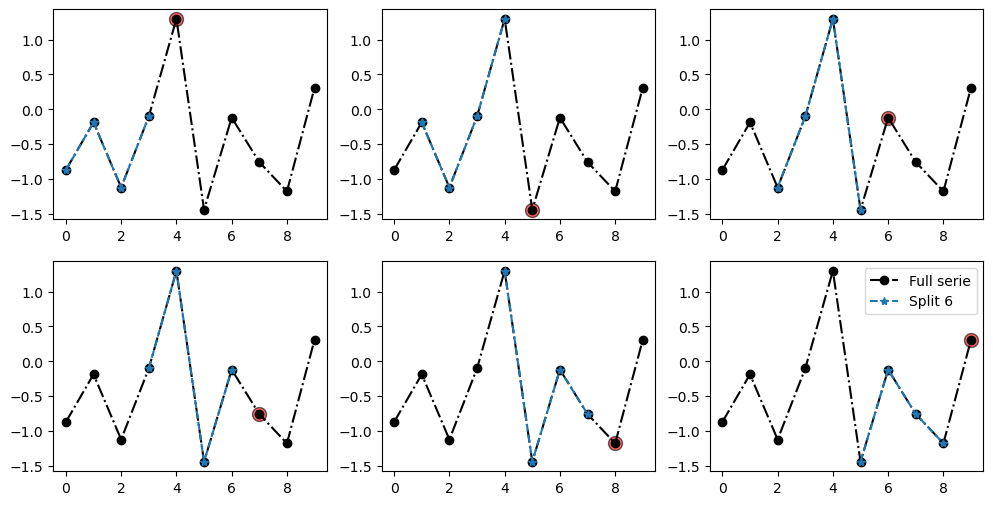

In [440]:
ts_windower.plot_splits(X_randn, X_window, y_window)